In this notebook, I show an example of training a template on a simulated data set. I manually iterate the perturbations so I can save multiple steps along the way to show the progession.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, copy

from modules import get_bandpass_dict, get_eff_wavelen, \
                    get_bandpass_functions, Sed, perturb_template

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')

Load one of the CWW+SB4 templates:

In [3]:
name = 'templates/ssp_5Myr_z008.sed'
x,y = np.loadtxt(name,unpack=True)
x /= 10 # convert wavelengths Angstroms -> nm
sed = Sed()
sed.wavelen = x
sed.flambda = y
del x,y

Load the filters

In [4]:
bandpass_dict = get_bandpass_dict(filter_loc='filters/')

Create a set of redshifted photometry

In [5]:
photometry = []
filters = list(bandpass_dict.keys())
random.seed(11)
for i in range(200):
    sed_ = copy.deepcopy(sed)
    redshift = np.random.rand()*5
    sed_.redshift(redshift)
    eff_wavelen = get_eff_wavelen(bandpass_dict)
    wavelen = eff_wavelen/(1+redshift)
    
    fluxes = sed_.fluxlist(bandpass_dict)
    fluxes = [random.gauss(i,0.1*i) for i in fluxes]
    
    for i in range(len(wavelen)):
        photometry.append([wavelen[i],fluxes[i],0.1*fluxes[i],redshift,filters[i]])

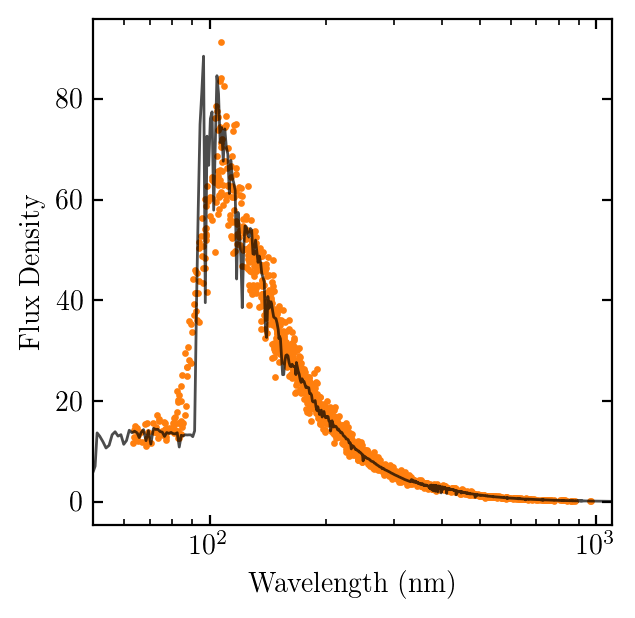

In [6]:
# plot photometry
wavelen = [i[0] for i in photometry]
flux  = [i[1] for i in photometry]
plt.scatter(wavelen,flux,c='C1',s=2)

# plot original template
plt.plot(sed.wavelen,sed.flambda,c='k',lw=1,alpha=0.7)

plt.xlim(50,1100)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux Density")
plt.xscale('log')
plt.show()

Create a naive template

In [7]:
template = Sed()
template.wavelen = np.geomspace(10,1150,300)
template.flambda = 0*template.wavelen + 5.0

And perturb it 100 times

In [9]:
%%time
history = dict()
save = [1,5,10,20,30,40,50,60,70,80,90,100]
new_template = copy.deepcopy(template)
for i in range(100):
    sol = perturb_template(new_template,photometry,bandpass_dict)
    new_template.flambda += sol
    if i + 1 in save:
        history[i+1] = copy.deepcopy(new_template)

CPU times: user 15min 3s, sys: 1min, total: 16min 3s
Wall time: 46.6 s


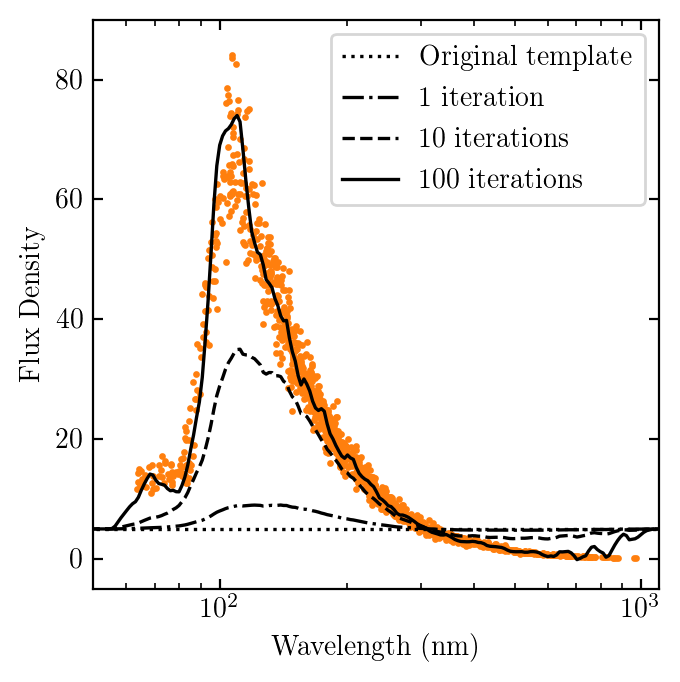

In [10]:
fig,ax = plt.subplots()

# plot the photometry
wavelen = [i[0] for i in photometry]
flux  = [i[1] for i in photometry]
ax.scatter(wavelen,flux,c='C1',s=2)

# plot different stages of training
ax.plot(template.wavelen,template.flambda,label='Original template',c='k',ls=':')
ax.plot(history[1].wavelen,history[1].flambda,label='1 iteration',c='k',ls='-.')
ax.plot(history[10].wavelen,history[10].flambda,label='10 iterations',c='k',ls='--')
ax.plot(history[100].wavelen,history[100].flambda,label='100 iterations',c='k',ls='-')

ax.legend()

ax.set_xlim(50,1100)
ax.set_ylim(-5,90)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux Density")
plt.xscale('log')

plt.tight_layout(pad=0.5)
#fig.savefig('plots/training_example.pdf')